In [9]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import time
from scipy.io import wavfile
from scipy import signal

### Задание 1

Для уменьшения количества точек, но сохранения количества кадров будем вырезать ровно середину кадра, т.к длина стрелок и сам циферблат не имеют значения, а взаимное расположение стрелок можно понять по имеющейся информации 

In [39]:
import cv2
import numpy as np
import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

# 1. Загрузка видеофайла
video_path = r'C:\Users\skills\Downloads\Модуль 2\training_datasets\clock.mp4'
cap = cv2.VideoCapture(video_path)

# Получаем параметры видео
fps = cap.get(cv2.CAP_PROP_FPS)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Исходный объем данных
original_data_points = frame_count * width * height * 3  # 3 для RGB

# 1.1. Предобработка: обрезка центральной части изображения
frames = []
crop_size_x = width // 20  
crop_size_y = height // 20  

# Извлечение всех кадров
for i in range(frame_count):
    ret, frame = cap.read()
    if not ret:
        break
    # Находим координаты для обрезки
    center_x, center_y = width // 2, height // 2
    center_crop = frame[
        center_y - crop_size_y:center_y + crop_size_y,
        center_x - crop_size_x:center_x + crop_size_x
    ]
    frames.append(center_crop)

cap.release()

# Новое количество точек
new_width = 2 * crop_size_x
new_height = 2 * crop_size_y
new_data_points = len(frames) * new_width * new_height * 3  # Новый размер после обрезки
print(f"Исходное количество точек: {original_data_points}")
print(f"Количество точек после предобработки: {new_data_points}")
print(f"Соотношение: {original_data_points / new_data_points}")

Исходное количество точек: 29859840000
Количество точек после предобработки: 298598400
Соотношение: 100.0


In [40]:
# 1.2. Создание разметки
targets = []
for i in range(len(frames)):
    # Кадры идут с 0:00:00
    timestamp = datetime.timedelta(seconds=i)  
    targets.append((timestamp.seconds // 3600, (timestamp.seconds // 60) % 60, timestamp.seconds % 60))

targets = np.array(targets)  # Преобразуем в массив NumPy


In [41]:
# 1.3. Разделение на обучающую и тестовую выборки
X = np.array(frames)  # Кадры
y = targets  # Таргеты

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
# 2. Создание и оценка моделей машинного обучения
# Создаем собственную метрику
def custom_metric(y_true, y_pred):
    # Преобразуем все в секунды
    true_seconds = y_true[:, 0] * 3600 + y_true[:, 1] * 60 + y_true[:, 2]
    pred_seconds = y_pred[:, 0] * 3600 + y_pred[:, 1] * 60 + y_pred[:, 2]
    return np.mean(np.abs(true_seconds - pred_seconds) / 3600)  # Отклонение в часах

# Обучение и оценка моделей
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train.reshape(len(X_train), -1), y_train)  # Преобразуем в 2D
    y_pred = model.predict(X_test.reshape(len(X_test), -1))
    score = custom_metric(y_test, y_pred)
    print(f"{model.__class__.__name__} Custom Metric: {score}")

In [ ]:
# Словарь моделей
models = {
    "RandomForestRegressor": RandomForestRegressor(),
    "GradientBoostingRegressor": GradientBoostingRegressor(),
    "LinearRegression": LinearRegression()
}

# Обучение и оценка всех моделей
for model_name, model in models.items():
    train_and_evaluate_model(model, X_train, y_train, X_test, y_test)

### Задание 2

In [10]:
# Загрузка WAV файла
file_path = r'C:\Users\skills\Downloads\Модуль 2\training_datasets\audio.wav'  # Укажите путь к вашему WAV файлу
sample_rate, data = wavfile.read(file_path)

C:\Users\skills\AppData\Local\Temp\ipykernel_8996\1569985860.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, data = wavfile.read(file_path)


In [11]:
# Проверка, если сигнал стерео, то преобразуем в моно
if len(data.shape) > 1:
    data = data.mean(axis=1)

In [13]:
# Генерация спектрограммы
f, t, Sxx = signal.spectrogram(data, sample_rate)

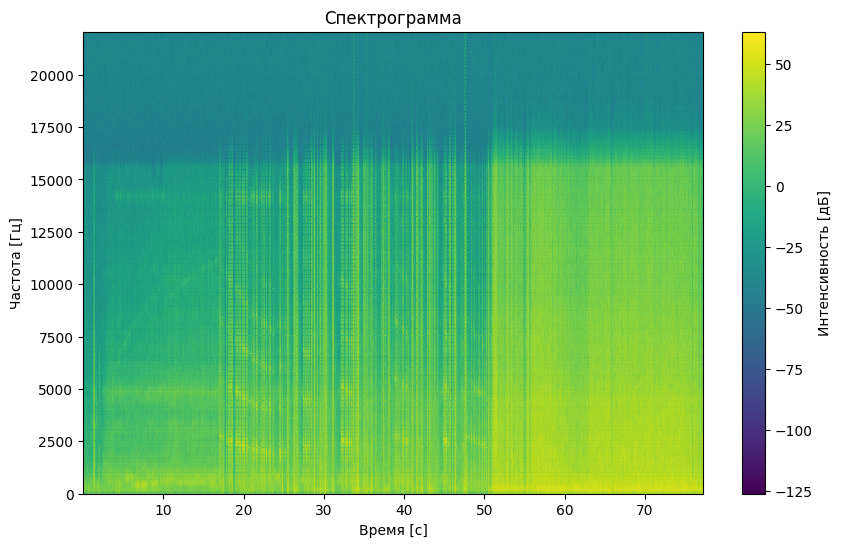

In [14]:
# Визуализация спектрограммы
plt.figure(figsize=(10, 6))
plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
plt.ylabel('Частота [Гц]')
plt.xlabel('Время [с]')
plt.title('Спектрограмма')
plt.colorbar(label='Интенсивность [дБ]')
plt.show()

In [15]:
# Выполняем преобразование Фурье
fft_result = np.fft.fft(data)
fft_magnitude = np.abs(fft_result)

# Создание частотной оси
frequencies = np.fft.fftfreq(len(fft_result), 1/sample_rate)

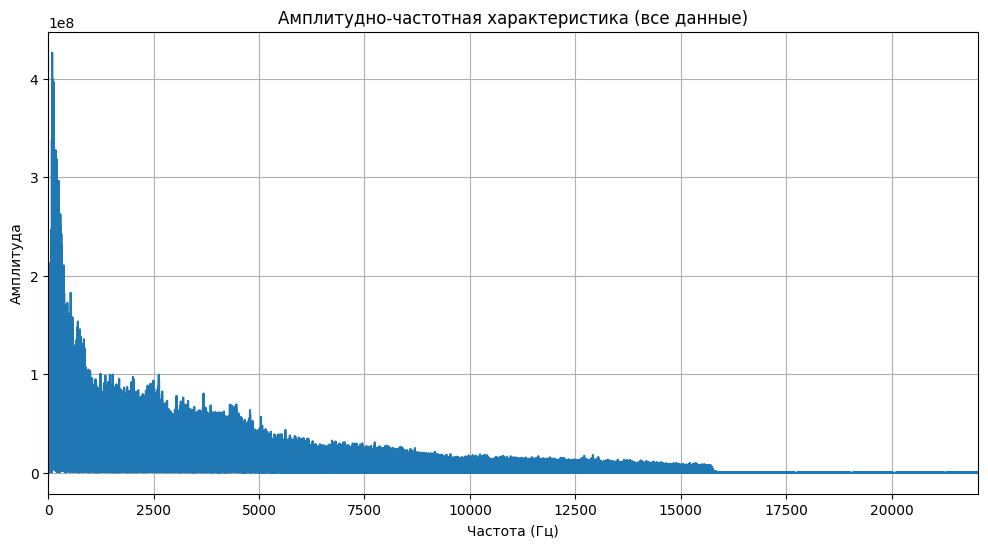

In [16]:
# Построение АЧХ для всего набора данных
plt.figure(figsize=(12, 6))
plt.plot(frequencies[:len(frequencies)//2], fft_magnitude[:len(fft_magnitude)//2])
plt.title('Амплитудно-частотная характеристика (все данные)')
plt.xlabel('Частота (Гц)')
plt.ylabel('Амплитуда')
plt.grid()
plt.xlim(0, sample_rate/2)  # Ограничиваем ось X до половины частоты дискретизации
plt.show()

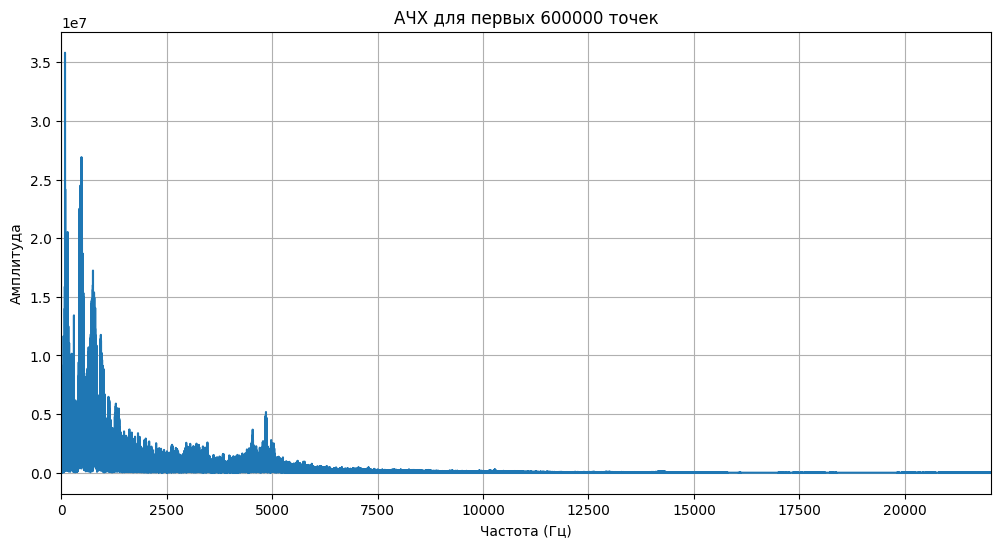

In [17]:
# Построение АЧХ для первых 600000 точек
if len(data) >= 600000:
    fft_first_600k = np.fft.fft(data[:600000])
    fft_magnitude_first_600k = np.abs(fft_first_600k)
    frequencies_first_600k = np.fft.fftfreq(len(fft_first_600k), 1/sample_rate)

    plt.figure(figsize=(12, 6))
    plt.plot(frequencies_first_600k[:len(frequencies_first_600k)//2], fft_magnitude_first_600k[:len(fft_magnitude_first_600k)//2])
    plt.title('АЧХ для первых 600000 точек')
    plt.xlabel('Частота (Гц)')
    plt.ylabel('Амплитуда')
    plt.grid()
    plt.xlim(0, sample_rate/2)
    plt.show()

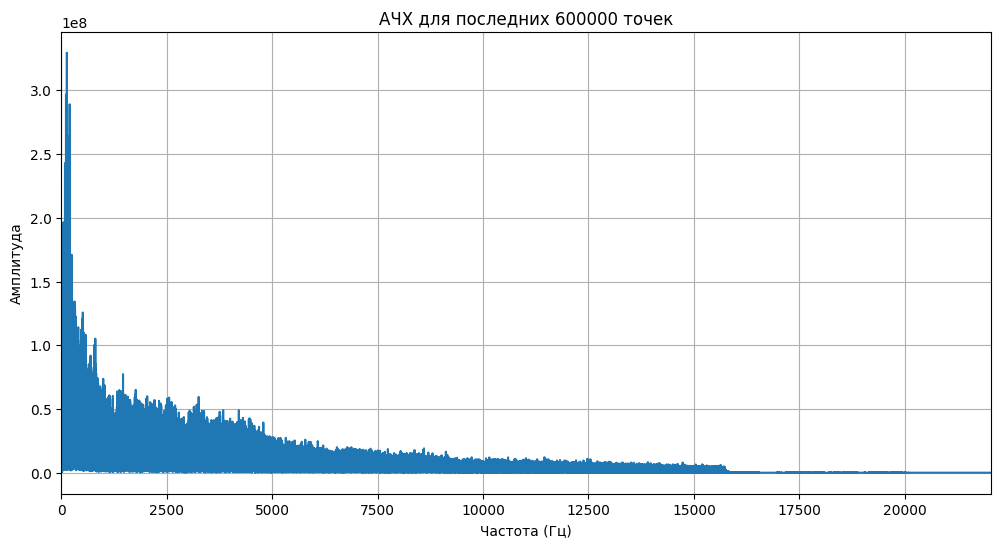

In [18]:
# Построение АЧХ для последних 600000 точек
if len(data) >= 600000:
    fft_last_600k = np.fft.fft(data[-600000:])
    fft_magnitude_last_600k = np.abs(fft_last_600k)
    frequencies_last_600k = np.fft.fftfreq(len(fft_last_600k), 1/sample_rate)

    plt.figure(figsize=(12, 6))
    plt.plot(frequencies_last_600k[:len(frequencies_last_600k)//2], fft_magnitude_last_600k[:len(fft_magnitude_last_600k)//2])
    plt.title('АЧХ для последних 600000 точек')
    plt.xlabel('Частота (Гц)')
    plt.ylabel('Амплитуда')
    plt.grid()
    plt.xlim(0, sample_rate/2)
    plt.show()

Вывод:
1. В первый промежуток времени наблюдаются довольно сильные по сранвению с предыдущими скачки. Возможно, шумы и помехи в начале записи
2. В последних точках все более равномерно, что подтверждает предыдущий вывод.
3. По всем графикам можно сделать вывод об обратной зависимости амплитуды и частоты (чем больше частота, тем меньше амплитуда)

In [19]:
from scipy.signal import resample

# Определяем длительность сигнала в секундах
duration = len(data) / sample_rate

# Определяем количество окон по 1 секунде
num_windows = int(duration)

In [20]:
# Инициализируем массивы для аггрегирующих характеристик
mean_amplitude = np.zeros(num_windows)
max_amplitude = np.zeros(num_windows)
min_amplitude = np.zeros(num_windows)
std_amplitude = np.zeros(num_windows)
energy = np.zeros(num_windows)

In [21]:
# Заполняем массивы аггрегирующих характеристик
for i in range(num_windows):
    window_data = data[i * sample_rate:(i + 1) * sample_rate]
    mean_amplitude[i] = np.mean(window_data)
    max_amplitude[i] = np.max(window_data)
    min_amplitude[i] = np.min(window_data)
    std_amplitude[i] = np.std(window_data)
    energy[i] = np.sum(window_data ** 2)


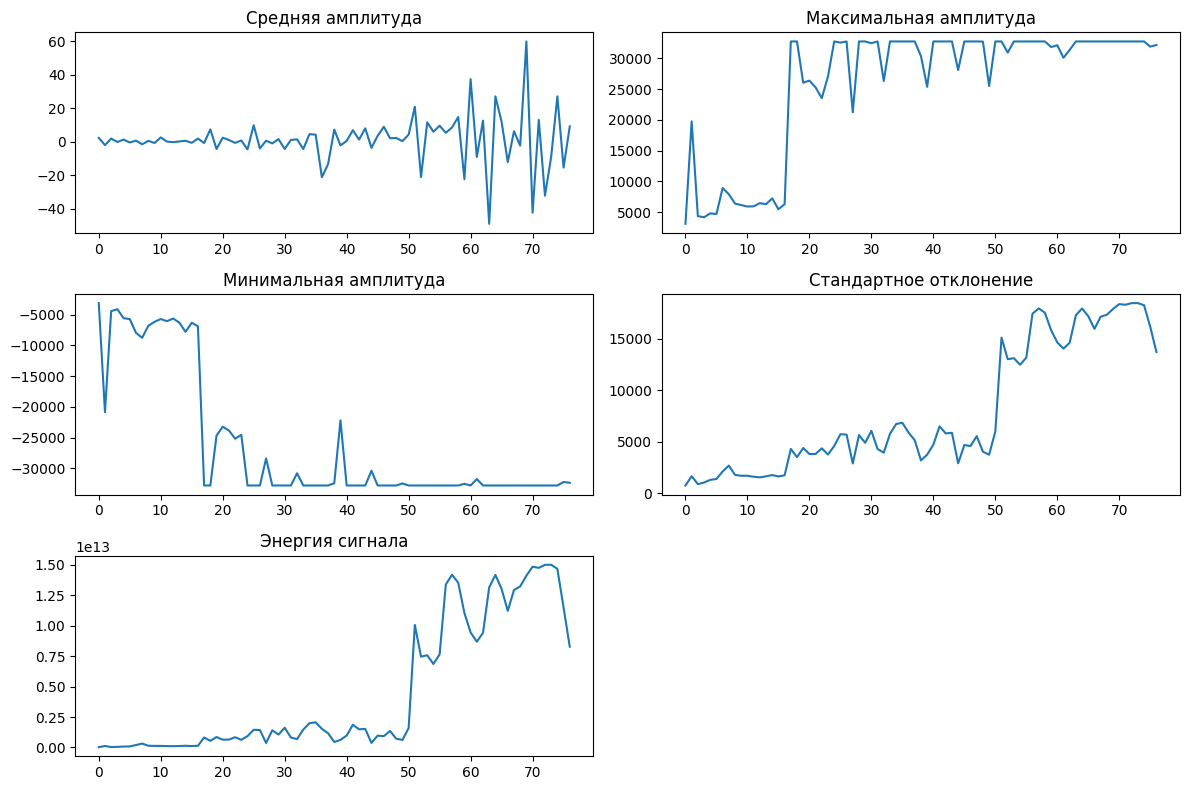

In [22]:
# Визуализация аггрегирующих характеристик
plt.figure(figsize=(12, 8))

plt.subplot(3, 2, 1)
plt.plot(mean_amplitude)
plt.title('Средняя амплитуда')

plt.subplot(3, 2, 2)
plt.plot(max_amplitude)
plt.title('Максимальная амплитуда')

plt.subplot(3, 2, 3)
plt.plot(min_amplitude)
plt.title('Минимальная амплитуда')

plt.subplot(3, 2, 4)
plt.plot(std_amplitude)
plt.title('Стандартное отклонение')

plt.subplot(3, 2, 5)
plt.plot(energy)
plt.title('Энергия сигнала')

plt.tight_layout()
plt.show()

Text(0, 0.5, 'Амплитуда')

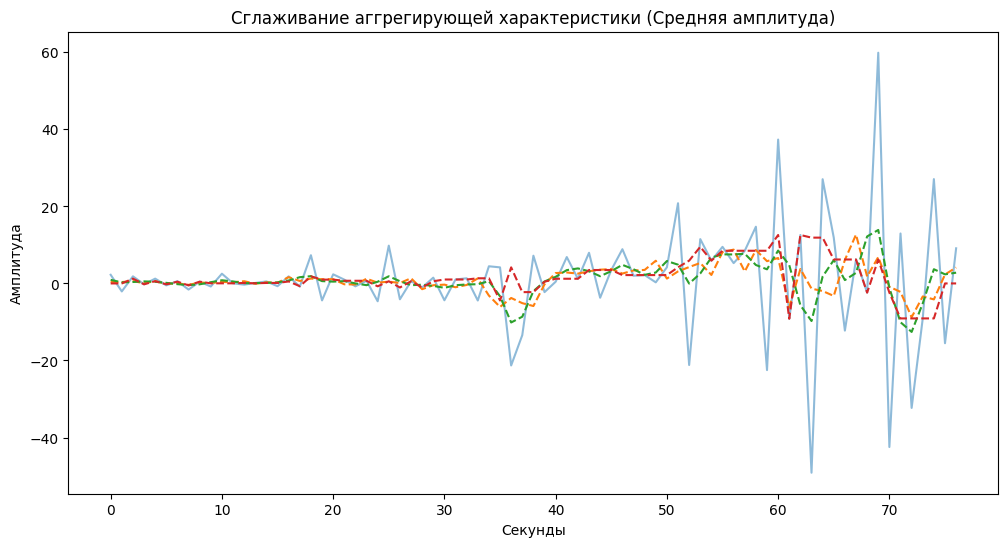

In [23]:
from scipy.ndimage import gaussian_filter1d
from scipy.signal import medfilt

# Сглаживание с помощью скользящего среднего
window_size = 5
smoothed_mean = np.convolve(mean_amplitude, np.ones(window_size)/window_size, mode='same')

# Сглаживание с помощью гауссового фильтра
sigma = 1
smoothed_gaussian = gaussian_filter1d(mean_amplitude, sigma=sigma)

# Сглаживание с помощью медианного фильтра
smoothed_median = medfilt(mean_amplitude, kernel_size=5)

# Визуализация сглаживания
plt.figure(figsize=(12, 6))

plt.plot(mean_amplitude, label='Исходная средняя амплитуда', alpha=0.5)
plt.plot(smoothed_mean, label='Скользящее среднее', linestyle='--')
plt.plot(smoothed_gaussian, label='Гауссово сглаживание', linestyle='--')
plt.plot(smoothed_median, label='Медианное сглаживание', linestyle='--')

plt.title('Сглаживание аггрегирующей характеристики (Средняя амплитуда)')
plt.xlabel('Секунды')
plt.ylabel('Амплитуда')

Text(0, 0.5, 'Амплитуда')

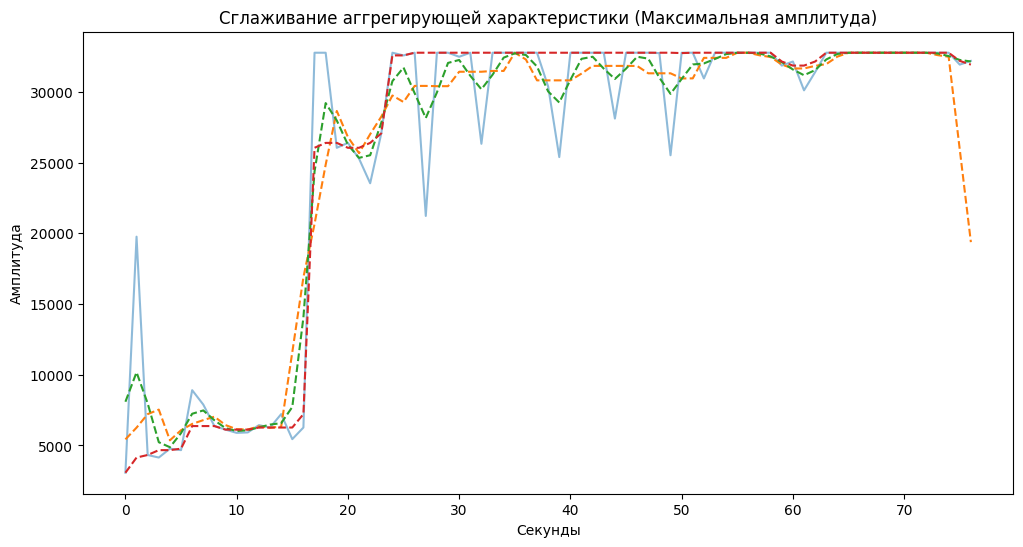

In [24]:
# Сглаживание с помощью скользящего среднего
window_size = 5
smoothed_mean = np.convolve(max_amplitude, np.ones(window_size)/window_size, mode='same')

# Сглаживание с помощью гауссового фильтра
sigma = 1
smoothed_gaussian = gaussian_filter1d(max_amplitude, sigma=sigma)

# Сглаживание с помощью медианного фильтра
smoothed_median = medfilt(max_amplitude, kernel_size=5)

# Визуализация сглаживания
plt.figure(figsize=(12, 6))

plt.plot(max_amplitude, label='Исходная максимальная амплитуда', alpha=0.5)
plt.plot(smoothed_mean, label='Скользящее среднее', linestyle='--')
plt.plot(smoothed_gaussian, label='Гауссово сглаживание', linestyle='--')
plt.plot(smoothed_median, label='Медианное сглаживание', linestyle='--')

plt.title('Сглаживание аггрегирующей характеристики (Максимальная амплитуда)')
plt.xlabel('Секунды')
plt.ylabel('Амплитуда')

Text(0, 0.5, 'Амплитуда')

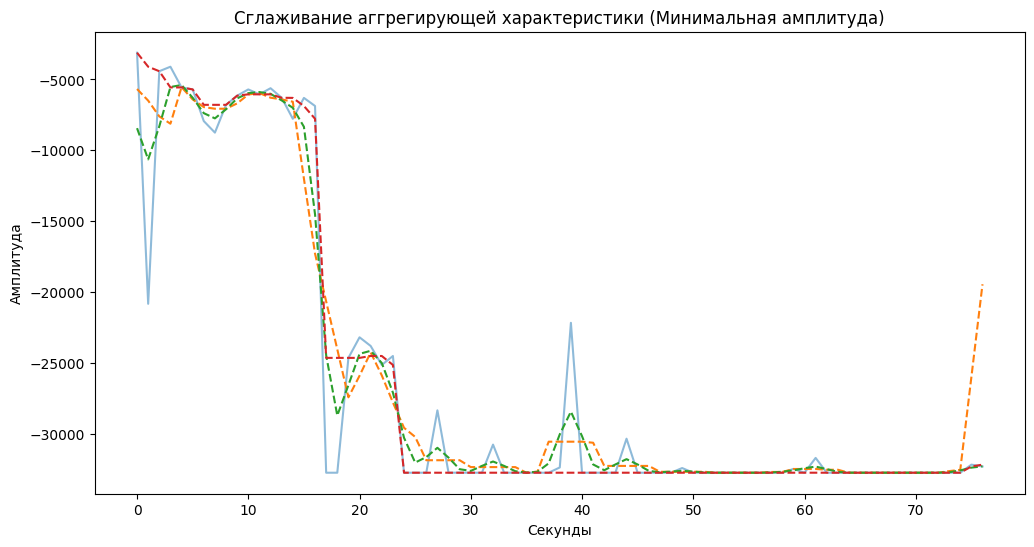

In [25]:
# Сглаживание с помощью скользящего среднего
window_size = 5
smoothed_mean = np.convolve(min_amplitude, np.ones(window_size)/window_size, mode='same')

# Сглаживание с помощью гауссового фильтра
sigma = 1
smoothed_gaussian = gaussian_filter1d(min_amplitude, sigma=sigma)

# Сглаживание с помощью медианного фильтра
smoothed_median = medfilt(min_amplitude, kernel_size=5)

# Визуализация сглаживания
plt.figure(figsize=(12, 6))

plt.plot(min_amplitude, label='Исходная минимальная амплитуда', alpha=0.5)
plt.plot(smoothed_mean, label='Скользящее среднее', linestyle='--')
plt.plot(smoothed_gaussian, label='Гауссово сглаживание', linestyle='--')
plt.plot(smoothed_median, label='Медианное сглаживание', linestyle='--')

plt.title('Сглаживание аггрегирующей характеристики (Минимальная амплитуда)')
plt.xlabel('Секунды')
plt.ylabel('Амплитуда')

Text(0, 0.5, 'Отклонение')

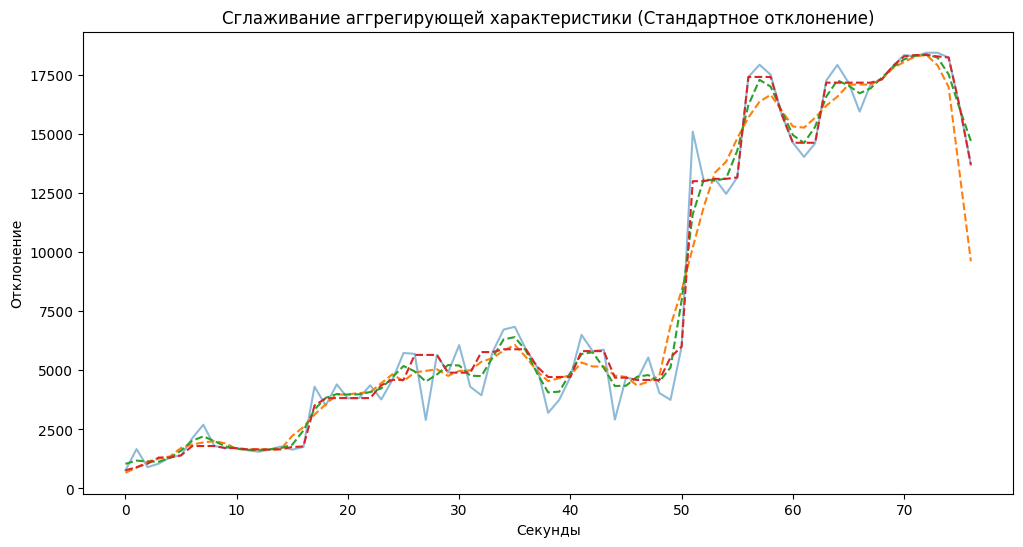

In [26]:
# Сглаживание с помощью скользящего среднего
window_size = 5
smoothed_mean = np.convolve(std_amplitude, np.ones(window_size)/window_size, mode='same')

# Сглаживание с помощью гауссового фильтра
sigma = 1
smoothed_gaussian = gaussian_filter1d(std_amplitude, sigma=sigma)

# Сглаживание с помощью медианного фильтра
smoothed_median = medfilt(std_amplitude, kernel_size=5)

# Визуализация сглаживания
plt.figure(figsize=(12, 6))

plt.plot(std_amplitude, label='Исходное стандартное отклонение', alpha=0.5)
plt.plot(smoothed_mean, label='Скользящее среднее', linestyle='--')
plt.plot(smoothed_gaussian, label='Гауссово сглаживание', linestyle='--')
plt.plot(smoothed_median, label='Медианное сглаживание', linestyle='--')

plt.title('Сглаживание аггрегирующей характеристики (Стандартное отклонение)')
plt.xlabel('Секунды')
plt.ylabel('Отклонение')

Text(0, 0.5, 'Энергия')

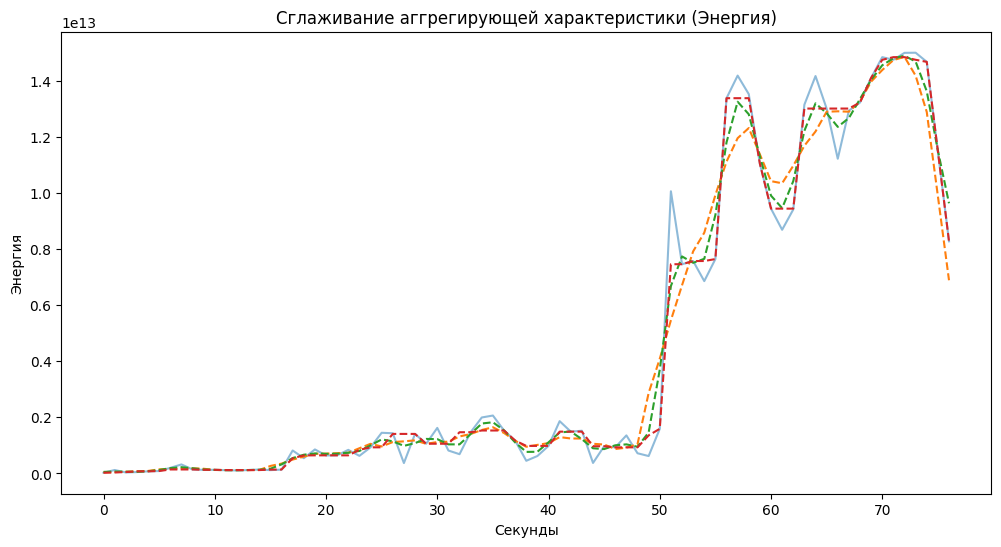

In [27]:
# Сглаживание с помощью скользящего среднего
window_size = 5
smoothed_mean = np.convolve(energy, np.ones(window_size)/window_size, mode='same')

# Сглаживание с помощью гауссового фильтра
sigma = 1
smoothed_gaussian = gaussian_filter1d(energy, sigma=sigma)

# Сглаживание с помощью медианного фильтра
smoothed_median = medfilt(energy, kernel_size=5)

# Визуализация сглаживания
plt.figure(figsize=(12, 6))

plt.plot(energy, label='Исходное стандартное отклонение', alpha=0.5)
plt.plot(smoothed_mean, label='Скользящее среднее', linestyle='--')
plt.plot(smoothed_gaussian, label='Гауссово сглаживание', linestyle='--')
plt.plot(smoothed_median, label='Медианное сглаживание', linestyle='--')

plt.title('Сглаживание аггрегирующей характеристики (Энергия)')
plt.xlabel('Секунды')
plt.ylabel('Энергия')

### Задание 3

В качестве метрики используется силуэтный коэффициент. Этому есть несколько причин:
1. Не требует разметки
2. Встроен в библиотеки
3. Легко интерпретируем

In [2]:
#считывание файла
df = pd.read_csv(r'C:\Users\skills\Downloads\Модуль 2\training_datasets\higgs.csv')
df

C:\Users\skills\AppData\Local\Temp\ipykernel_8996\1990340731.py:2: DtypeWarning: Columns (20,21,22,23,24,25,26,27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r'C:\Users\skills\Downloads\Модуль 2\training_datasets\higgs.csv')


,is_boson,lepton_pT,lepton_eta,lepton_phi,missing_energy_magnitude,missing_energy_phi,jet1pt,jet1eta,jet1phi,jet1b-tag,...,jet4eta,jet4phi,jet4b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
0,1,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,...,-1.138930,-0.000819,0.0,0.30222,0.833048,0.9857,0.978098,0.779732,0.992356,0.798343
1,1,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,...,1.128848,0.900461,0.0,0.909753,1.10833,0.985692,0.951331,0.803252,0.865924,0.780118
2,0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,...,-0.678379,-1.360356,0.0,0.946652,1.028704,0.998656,0.728281,0.8692,1.026736,0.957904
3,1,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,...,-0.373566,0.113041,0.0,0.755856,1.361057,0.98661,0.838085,1.133295,0.872245,0.808487
4,0,1.595839,-0.607811,0.007075,1.818450,-0.111906,0.847550,-0.566437,1.581239,2.173076,...,-0.654227,-1.274345,3.101961,0.823761,0.938191,0.971758,0.789176,0.430553,0.961357,0.957818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98045,1,0.908091,-0.825006,-0.830871,0.736298,1.512713,0.881811,-0.363440,0.006813,1.086538,...,-0.187013,0.716784954071045,0,1.31768071651459,1.01079499721527,0.985962450504303,0.957878351211548,1.45467174053192,0.903936803340912,0.786069393157959
98046,0,2.512898,0.530759,-1.470626,1.641798,1.613386,0.934027,1.521958,-0.049836,0.000000,...,0.053673,-0.386482894420624,0,0.774412572383881,0.745262801647186,0.99708765745163,1.39238667488098,0.86468094587326,1.17978250980377,1.08616733551025
98047,0,0.903699,0.261943,-0.429149,1.892855,0.313687,0.493396,-1.494282,-1.458506,0.000000,...,-0.283621,1.1107724905014,3.10196137428284,0.527038097381592,0.60726273059845,1.12528610229492,0.634106457233429,0.115543350577354,0.425828188657761,0.692506015300751
98048,0,0.566047,-0.317568,0.062561,0.358186,-1.315823,0.691176,1.154583,-0.242759,2.173076,...,-0.844943,-0.294922441244125,0,0.747239172458649,1.0089750289917,0.989497303962708,1.20314705371857,0.8924919962883,1.09080731868744,0.888965249061584


In [3]:
# Функция для замены знака вопроса на среднее значение столбца
def replace_question_with_mean(df, column):
    # Заменяем знак вопроса на NaN
    df[column].replace('?', np.nan, inplace=True)
    
    # Преобразуем столбец в числовой тип (если необходимо)
    df[column] = pd.to_numeric(df[column], errors='coerce')
    
    # Вычисляем среднее значение, игнорируя NaN
    mean_value = df[column].mean()
    
    # Заменяем NaN (включая те, что были заменены с вопросом) на среднее значение
    df[column].fillna(mean_value, inplace=True)

for col in df.columns:
    replace_question_with_mean (df, col)

# Выводим результат
df

C:\Users\skills\AppData\Local\Temp\ipykernel_8996\4071041004.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].replace('?', np.nan, inplace=True)
C:\Users\skills\AppData\Local\Temp\ipykernel_8996\4071041004.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For examp

,is_boson,lepton_pT,lepton_eta,lepton_phi,missing_energy_magnitude,missing_energy_phi,jet1pt,jet1eta,jet1phi,jet1b-tag,...,jet4eta,jet4phi,jet4b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
0,1,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,...,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
1,1,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,...,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
2,0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,...,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
3,1,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,...,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487
4,0,1.595839,-0.607811,0.007075,1.818450,-0.111906,0.847550,-0.566437,1.581239,2.173076,...,-0.654227,-1.274345,3.101961,0.823761,0.938191,0.971758,0.789176,0.430553,0.961357,0.957818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98045,1,0.908091,-0.825006,-0.830871,0.736298,1.512713,0.881811,-0.363440,0.006813,1.086538,...,-0.187013,0.716785,0.000000,1.317681,1.010795,0.985962,0.957878,1.454672,0.903937,0.786069
98046,0,2.512898,0.530759,-1.470626,1.641798,1.613386,0.934027,1.521958,-0.049836,0.000000,...,0.053673,-0.386483,0.000000,0.774413,0.745263,0.997088,1.392387,0.864681,1.179783,1.086167
98047,0,0.903699,0.261943,-0.429149,1.892855,0.313687,0.493396,-1.494282,-1.458506,0.000000,...,-0.283621,1.110772,3.101961,0.527038,0.607263,1.125286,0.634106,0.115543,0.425828,0.692506
98048,0,0.566047,-0.317568,0.062561,0.358186,-1.315823,0.691176,1.154583,-0.242759,2.173076,...,-0.844943,-0.294922,0.000000,0.747239,1.008975,0.989497,1.203147,0.892492,1.090807,0.888965


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98050 entries, 0 to 98049
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   is_boson                  98050 non-null  int64  
 1   lepton_pT                 98050 non-null  float64
 2   lepton_eta                98050 non-null  float64
 3   lepton_phi                98050 non-null  float64
 4   missing_energy_magnitude  98050 non-null  float64
 5   missing_energy_phi        98050 non-null  float64
 6   jet1pt                    98050 non-null  float64
 7   jet1eta                   98050 non-null  float64
 8   jet1phi                   98050 non-null  float64
 9   jet1b-tag                 98050 non-null  float64
 10  jet2pt                    98050 non-null  float64
 11  jet2eta                   98050 non-null  float64
 12  jet2phi                   98050 non-null  float64
 13  jet2b-tag                 98050 non-null  float64
 14  jet3pt

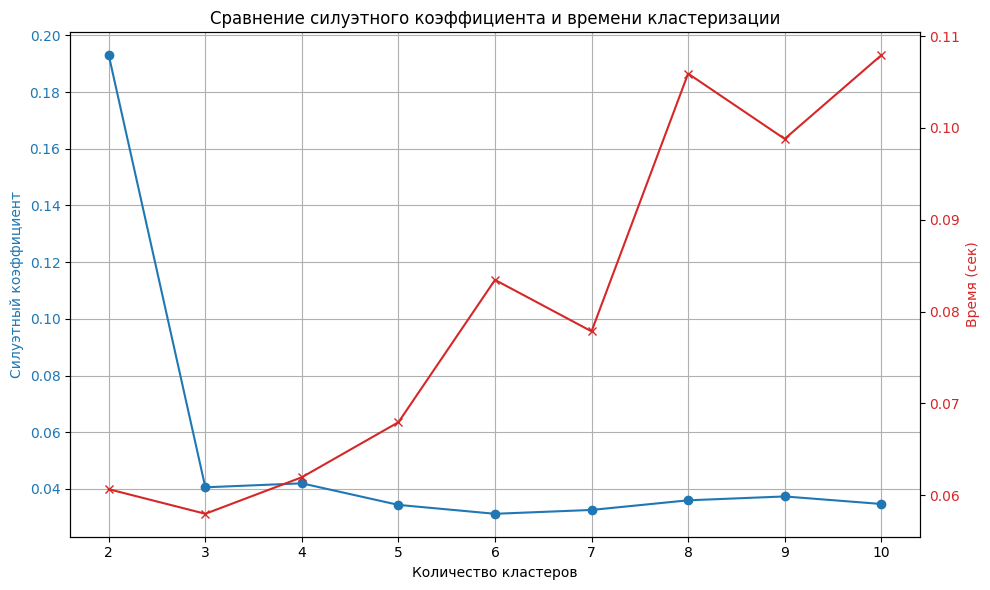

In [6]:
# Функция для выполнения кластерного анализа и вычисления силуэтного коэффициента
def evaluate_clusters(dataframe, min_clusters=2, max_clusters=10):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(dataframe)

    silhouette_scores = []
    times = []

    for n_clusters in range(min_clusters, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)

        # Измеряем время выполнения
        start_time = time.time()
        kmeans.fit(scaled_data)
        end_time = time.time()

        # Получаем метки кластеров и вычисляем силуэтный коэффициент
        labels = kmeans.labels_
        silhouette_avg = silhouette_score(scaled_data, labels)

        silhouette_scores.append(silhouette_avg)
        times.append(end_time - start_time)  # Время выполнения

    return silhouette_scores, times

# Выполнение кластерного анализа
silhouette_scores, times = evaluate_clusters(df, 2, 10)

# Визуализация результатов
fig, ax1 = plt.subplots(figsize=(10, 6))

# График силуэтного коэффициента
color = 'tab:blue'
ax1.set_xlabel('Количество кластеров')
ax1.set_ylabel('Силуэтный коэффициент', color=color)
ax1.plot(range(2, 11), silhouette_scores, marker='o', color=color, label='Силуэтный коэффициент')
ax1.tick_params(axis='y', labelcolor=color)

# Создание второго y-axes для времени
ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Время (сек)', color=color)  
ax2.plot(range(2, 11), times, marker='x', color=color, label='Время кластеризации')
ax2.tick_params(axis='y', labelcolor=color)

# Заголовок и сетка
plt.title('Сравнение силуэтного коэффициента и времени кластеризации')
ax1.grid()
fig.tight_layout()  
plt.show()

Для анализа используется силуэтный коэффициент. Он показывает, насколько каждый объект схож с другими объектами, в который он был распределён. Оптимальное значение приближено к 1. 
В результате графика получаем, что оптимальное количество кластеров равно двум, т.к при данном значении максимально высок силуэтный коэффициент. 
Затрачивыаемое  время с ростом количеств акластеров растет, а вот силуэтный коэффициент падает, что говорит о том, что не нужно брать большое количествао кластеров 

In [29]:
df

,is_boson,lepton_pT,lepton_eta,lepton_phi,missing_energy_magnitude,missing_energy_phi,jet1pt,jet1eta,jet1phi,jet1b-tag,...,jet4eta,jet4phi,jet4b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
0,1,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,...,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
1,1,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,...,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
2,0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,...,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
3,1,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,...,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487
4,0,1.595839,-0.607811,0.007075,1.818450,-0.111906,0.847550,-0.566437,1.581239,2.173076,...,-0.654227,-1.274345,3.101961,0.823761,0.938191,0.971758,0.789176,0.430553,0.961357,0.957818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98045,1,0.908091,-0.825006,-0.830871,0.736298,1.512713,0.881811,-0.363440,0.006813,1.086538,...,-0.187013,0.716785,0.000000,1.317681,1.010795,0.985962,0.957878,1.454672,0.903937,0.786069
98046,0,2.512898,0.530759,-1.470626,1.641798,1.613386,0.934027,1.521958,-0.049836,0.000000,...,0.053673,-0.386483,0.000000,0.774413,0.745263,0.997088,1.392387,0.864681,1.179783,1.086167
98047,0,0.903699,0.261943,-0.429149,1.892855,0.313687,0.493396,-1.494282,-1.458506,0.000000,...,-0.283621,1.110772,3.101961,0.527038,0.607263,1.125286,0.634106,0.115543,0.425828,0.692506
98048,0,0.566047,-0.317568,0.062561,0.358186,-1.315823,0.691176,1.154583,-0.242759,2.173076,...,-0.844943,-0.294922,0.000000,0.747239,1.008975,0.989497,1.203147,0.892492,1.090807,0.888965


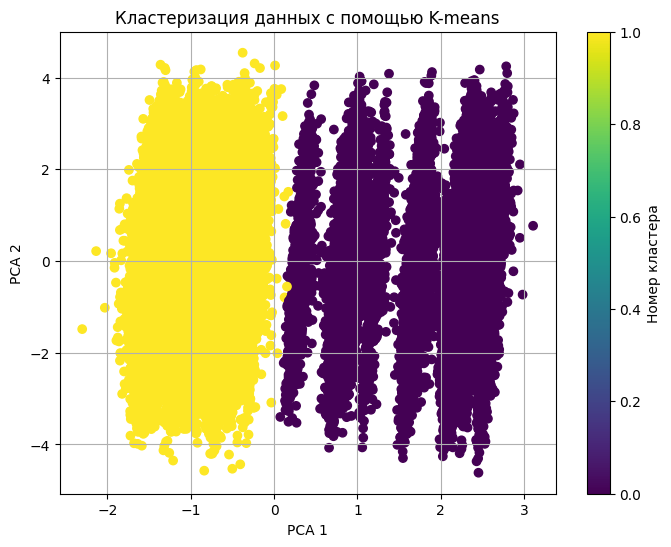

In [30]:
from sklearn.decomposition import PCA

# Кластеризация с использованием K-means
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(df)
labels = kmeans.labels_

# Добавляем метки кластеров в DataFrame
df['Cluster'] = labels

# Снижение размерности для визуализации (PCA)
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(df.iloc[:, :-1])  # исключаем столбец с метками кластеров

# Визуализация кластеров
plt.figure(figsize=(8, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=df['Cluster'], cmap='viridis', marker='o')
plt.title('Кластеризация данных с помощью K-means')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Номер кластера')
plt.grid()
plt.show()

Получили довольно четкое распределение между двумя кластерами, что может свидетельствовать о том, что в одном из кластеров все точки, являющиеся бозоном Хигса, а во втором -- все, что не являются ими. 

In [31]:
# Получение весов для PCA 1 и PCA 2
pca_components = pca.components_

In [32]:
# Веса для PCA 1
weights_pca1 = pca_components[0]

weights_pca1

array([ 1.10623693e-02, -1.17395112e-05,  1.98198628e-02, -1.47114094e-04,
        1.50570015e-03,  2.34325854e-03, -2.96696942e-03,  2.33524295e-02,
        5.22559657e-04, -1.45310018e-01, -7.10008565e-03,  9.56949918e-03,
       -5.86982449e-04, -1.55514697e-01, -1.93774556e-02,  2.59958032e-02,
        5.87401371e-04, -3.49450530e-01,  7.56973652e-02,  1.53829066e-02,
       -2.10552955e-03,  9.02482103e-01,  4.96054184e-02,  8.36489384e-03,
       -8.68452934e-04, -2.32623214e-02, -7.99977838e-02, -1.94179484e-02,
       -4.33600926e-03])

In [33]:
# Веса для PCA 2
weights_pca2 = pca_components[1]

weights_pca2

array([-1.45145737e-03, -6.44250922e-04,  4.75755524e-01,  9.02351198e-03,
       -3.60898440e-03, -5.29478774e-03, -1.20702097e-03,  4.77147925e-01,
       -1.79560731e-03,  1.16972216e-02,  2.47133635e-03,  4.63263815e-01,
       -4.28298960e-05,  1.68112482e-02,  1.15694174e-04,  4.34142726e-01,
       -2.79716533e-03, -9.89937883e-04, -4.28086704e-03,  3.74890315e-01,
       -5.56366475e-03, -4.09759354e-02, -3.35763621e-03, -1.16071480e-03,
       -5.96644526e-05,  6.65145760e-04,  6.61929437e-03,  1.12730547e-03,
        7.14802770e-05])

Исходя из имеющихся весов и анализа параметров, стоящих за этими весами, сделаем вывод, что в первой группе наблюдается бозон Хиггса, а во второй нет. 
В целом методы кластеризации хорошо подходят для поиска таких зависимостей, если правильно и точно выявить все необходимые параметры и откинуть шумовые, которые могут помешать интерпретации результатов. 